# Utils

In [1]:
import torch
import pyaudio
import wave
import os
import model.AudioUtil as AudioUtil
from model.SoundDS import SoundDS
# from model.AudioClassifier import AudioClassifier

print(torch.__version__)
model = torch.load('data/models/V8_model_fullV3.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)
model.eval()

CHUNK = 1050
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100

2.3.0+cu118
Using device: cuda:0


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def record_audio(duration=2):
    frames = []
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
    try:
        # Calculate the correct number of iterations to cover the duration
        num_frames = int((RATE / CHUNK) * duration)
        for _ in range(num_frames):
            data = stream.read(CHUNK)
            frames.append(data)
    finally:
        stream.stop_stream()
        stream.close()
        p.terminate()
    return frames

def save_temp_audio(frames, filename="temp_audio.wav"):
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(pyaudio.PyAudio().get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))

def process_audio_file(filename):
    class_names = {0: 'Noise', 1: 'Knock', 2: 'kn_se'} 
    aud = AudioUtil.open(filename)
    # os.remove(filename)
    # reaud = AudioUtil.resample(aud, RATE)
    # rechan = AudioUtil.rechannel(reaud, CHANNELS)
    # dur_aud = AudioUtil.pad_trunc(rechan, 2000)
    rechan = AudioUtil.rechannel(aud, 2)
    sgram = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None)
    # sgram = AudioUtil.spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    sgram = sgram.to(device)

    # sgram_tensor = torch.tensor(sgram).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        inputs = sgram

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        outputs = model(inputs.unsqueeze(0))

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs, 1)
        # Convert predictions and actual labels to class names
        predicted_classes = [class_names.get(p.item(), p.item()) for p in prediction][0]
        print(torch.round(outputs[0] * 100) / 100, predicted_classes)
    # print(prediction.item())
    # if prediction > 0.5:
    #     print("Klopfen erkannt!")

# Deleting bad Datapoints

## Getting bad datapoints

In [38]:
for file in os.listdir("data/train"):
    print(f"Processing {file}")
    process_audio_file(f"data/train/{file}")
# process_audio_file("data/validation/noise_81_var1.wav")

Processing knock_1.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var0.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var1.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var3.wav
tensor([0.0600, 0.9400, 0.0000], device='cuda:0') Knock
Processing knock_10_var5.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var6.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var7.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var8.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_10_var9.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_11.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_11_var0.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_11_var2.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_11_var4.wav
tensor([0., 1., 0.], device='cuda:0') Knock
Processing knock_11_var5.wav
tensor([0., 1., 0.], 

In [39]:
# noise_84 are knocks
# noise_70 
# noise_61_var
# noise_38
# noise_36

# knock_with_noise_9 is noise
# knock_with_noise_48
# knock_with_noise_29
# knock_with_noise_28
# knock_with_noise_24
# knock_with_noise_20 sehr unsicher


## deleting bad datapoints

In [42]:
import os
import glob

# Base names to match files for deletion
base_names = [
    "noise_84*", "noise_70*", "noise_61_var*", "noise_38*", "noise_36*",
    "knock_with_noise_9*", "knock_with_noise_48*", "knock_with_noise_29*",
    "knock_with_noise_28*", "knock_with_noise_24*", "knock_with_noise_20*"
]

# Directory where the files are located
directory = "data/test"

# Iterate over the base names and delete matching files
for base_name in base_names:
    # Create a pattern for glob to match
    pattern = os.path.join(directory, base_name)
    
    # Use glob to find files matching the pattern
    for file_path in glob.glob(pattern):
        # Delete the file
        os.remove(file_path)
        print(f"Deleted {file_path}")

Deleted data/test\knock_with_noise_29_var7.wav


# Testing Model

In [5]:
frames = record_audio()
save_temp_audio(frames)
process_audio_file("temp_audio.wav")

tensor([0., 1., 0.], device='cuda:0') Knock


In [4]:
print("Starte Klopfen-Erkennung...")
while True:
    frames = record_audio()
    save_temp_audio(frames)
    process_audio_file("temp_audio.wav")

Starte Klopfen-Erkennung...
tensor([0., 1., 0.], device='cuda:0') Knock
tensor([0., 1., 0.], device='cuda:0') Knock
tensor([0.0200, 0.9800, 0.0000], device='cuda:0') Knock
tensor([0., 1., 0.], device='cuda:0') Knock
tensor([0., 1., 0.], device='cuda:0') Knock
tensor([0., 1., 0.], device='cuda:0') Knock


KeyboardInterrupt: 

In [4]:

class_names = {0: 'Noise', 1: 'Knock', 2:'Kn_se'}  # Mapping class indices to class names

# ANSI escape codes for colors
RED = '\033[91m'   # Red text
RESET = '\033[0m'  # Reset to default color

# Disable gradient updates
with torch.no_grad():
    filename = "knock_1.wav"
    aud = AudioUtil.open(filename)
    rechan = AudioUtil.rechannel(aud, 2)
    inputs = AudioUtil.spectro_gram(rechan, n_mels=64, n_fft=1024, hop_len=None)
    inputs = inputs.to(device)

    ds = SoundDS('')


    # Normalize the inputs
    inputs_m, inputs_s = inputs.mean(), inputs.std()
    inputs = (inputs - inputs_m) / inputs_s

    # Get predictions
    outputs = model(inputs.unsqueeze(0))

    # Get the predicted class with the highest score
    _, prediction = torch.max(outputs, 1)
    # Convert predictions and actual labels to class names
    predicted_classes = [class_names.get(p.item(), p.item()) for p in prediction]
    row_len = 50
    # Prepare to print 10 predictions and actuals per line
    for i in range(0, len(predicted_classes), row_len):
        pred_slice = predicted_classes[i:i+row_len]
        print('Predictions: ', ' '.join(pred_slice))

Predictions:  Knock


In [3]:
def inference(model, val_dl):
    correct_prediction = 0
    total_prediction = 0
    class_names = {0: 'Noise', 1: 'Knock', 2:'Kn_se'}  # Mapping class indices to class names

    # ANSI escape codes for colors
    RED = '\033[91m'   # Red text
    RESET = '\033[0m'  # Reset to default color

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # Convert predictions and actual labels to class names
            predicted_classes = [class_names.get(p.item(), p.item()) for p in prediction]
            actual_classes = [class_names.get(l.item(), l.item()) for l in labels]
            row_len = 50
            # Prepare to print 10 predictions and actuals per line
            for i in range(0, len(predicted_classes), row_len):
                pred_slice = predicted_classes[i:i+row_len]
                actual_slice = actual_classes[i:i+row_len]
                pred_str = ', '.join([f'{RED if pred != actual else RESET}{pred}{RESET}' for pred, actual in zip(pred_slice, actual_slice)])
                actual_str = ', '.join([f'{RED if pred != actual else RESET}{actual}{RESET}' for pred, actual in zip(pred_slice, actual_slice)])
                print(f'Predicted: {pred_str}\nActual:    {actual_str}\n')

            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction / total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

In [9]:
%load_ext autoreload
%autoreload 2

In [5]:
from model.SoundDS import SoundDS
from torch.utils.data import DataLoader
# single_ds = SoundDS('data/validation')
single_ds = SoundDS('./')
single_dl = DataLoader(single_ds)

inference(model, single_dl)

Predicted: Knock
Actual:    Knock

Predicted: Knock
Actual:    Noise

Predicted: Knock
Actual:    Noise

Accuracy: 0.33, Total items: 3


In [6]:
import wave

def print_wave_info(file_path):
    """
    Druckt die grundlegenden Informationen einer WAV-Datei.
    """
    with wave.open(file_path, 'rb') as wav_file:
        print(f"Datei: {file_path}")
        print(f"Anzahl der Kanäle: {wav_file.getnchannels()}")
        print(f"Sample-Rate: {wav_file.getframerate()}")
        print(f"Sample-Breite (in Bytes): {wav_file.getsampwidth()}")
        print(f"Anzahl der Frames: {wav_file.getnframes()}")
        print(f"Parameter: {wav_file.getparams()}")
        print("--------------------------------------------------")

def compare_wave_files(file_path_1, file_path_2):
    """
    Vergleicht zwei WAV-Dateien und druckt ihre Eigenschaften.
    """
    print("Vergleich der WAV-Dateien:")
    print_wave_info(file_path_1)
    print_wave_info(file_path_2)

# Ersetzen Sie diese Pfade mit den Pfaden Ihrer WAV-Dateien
file_path_1 = 'knock_x.wav'
file_path_2 = 'data/train/knock_1.wav'

compare_wave_files(file_path_1, file_path_2)

Vergleich der WAV-Dateien:
Datei: knock_x.wav
Anzahl der Kanäle: 1
Sample-Rate: 44100
Sample-Breite (in Bytes): 2
Anzahl der Frames: 64667
Parameter: _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=64667, comptype='NONE', compname='not compressed')
--------------------------------------------------
Datei: data/train/knock_1.wav
Anzahl der Kanäle: 1
Sample-Rate: 44100
Sample-Breite (in Bytes): 2
Anzahl der Frames: 88200
Parameter: _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=88200, comptype='NONE', compname='not compressed')
--------------------------------------------------


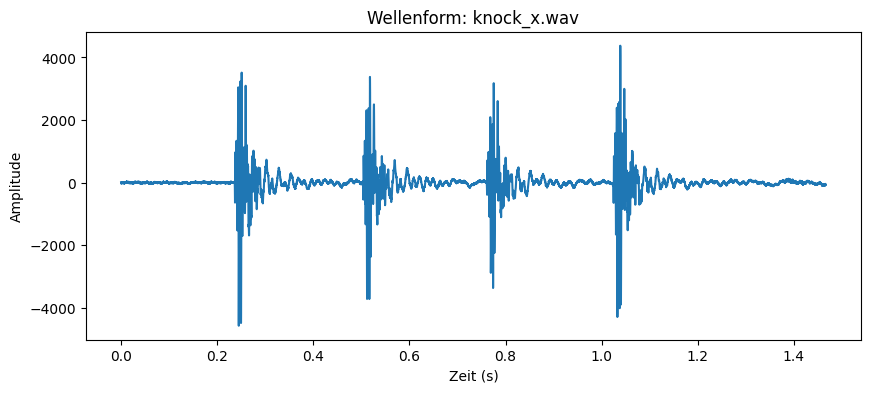

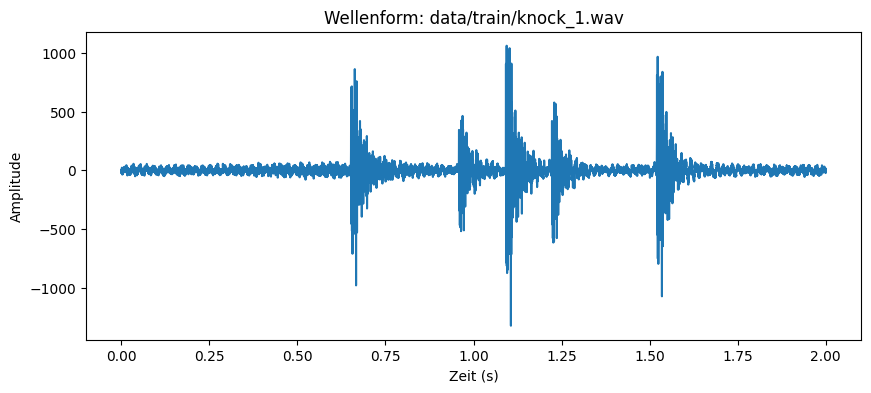

In [7]:
import matplotlib.pyplot as plt
from scipy.io import wavfile

def plot_wave(file_path):
    """
    Liest eine WAV-Datei und plottet die Wellenform.
    """
    # Lese die Sample-Rate und Audiodaten aus der WAV-Datei
    sample_rate, data = wavfile.read(file_path)
    
    # Erstelle Zeitachse basierend auf der Anzahl der Samples und der Sample-Rate
    time = [i / sample_rate for i in range(len(data))]
    
    # Plotte die Wellenform
    plt.figure(figsize=(10, 4))
    plt.plot(time, data)
    plt.title(f"Wellenform: {file_path}")
    plt.ylabel("Amplitude")
    plt.xlabel("Zeit (s)")
    plt.show()

# Ersetzen Sie diese Pfade mit den Pfaden Ihrer WAV-Dateien
file_path_1 = 'knock_x.wav'
file_path_2 = 'data/train/knock_1.wav'

plot_wave(file_path_1)
plot_wave(file_path_2)

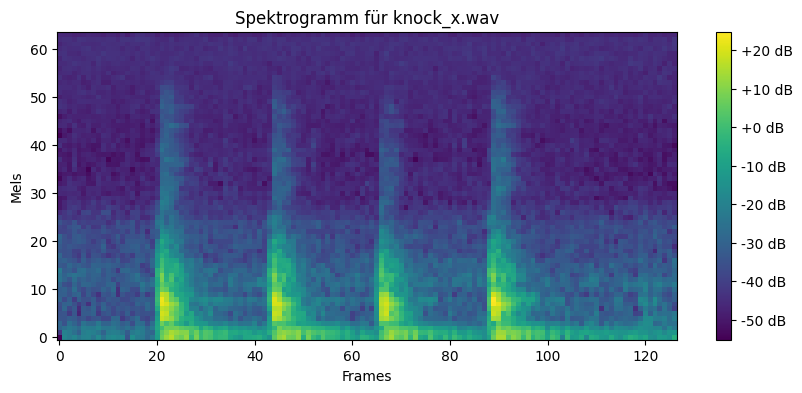

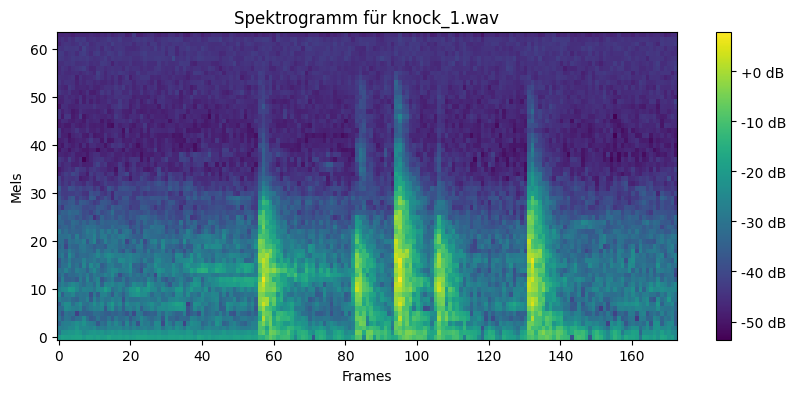

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Angenommen, AudioUtil ist bereits definiert und importiert

def plot_spectrogram(sgram, title):
    """
    Plottet das Spektrogramm.
    """
    plt.figure(figsize=(10, 4))
    plt.imshow(sgram, aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.ylabel('Mels')
    plt.xlabel('Frames')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Verarbeite und plotte das Spektrogramm für die erste Datei
aud1 = AudioUtil.open('knock_x.wav')
sgram1 = AudioUtil.spectro_gram(aud1, n_mels=64, n_fft=1024, hop_len=None)
plot_spectrogram(sgram1[0], 'Spektrogramm für knock_x.wav')

# Verarbeite und plotte das Spektrogramm für die zweite Datei
aud2 = AudioUtil.open('data/train/knock_1.wav')
sgram2 = AudioUtil.spectro_gram(aud2, n_mels=64, n_fft=1024, hop_len=None)
plot_spectrogram(sgram2[0], 'Spektrogramm für knock_1.wav')

[0. 0. 0. ... 0. 0. 0.]


ValueError: x and y must have same first dimension, but have shapes (88000,) and (88200,)

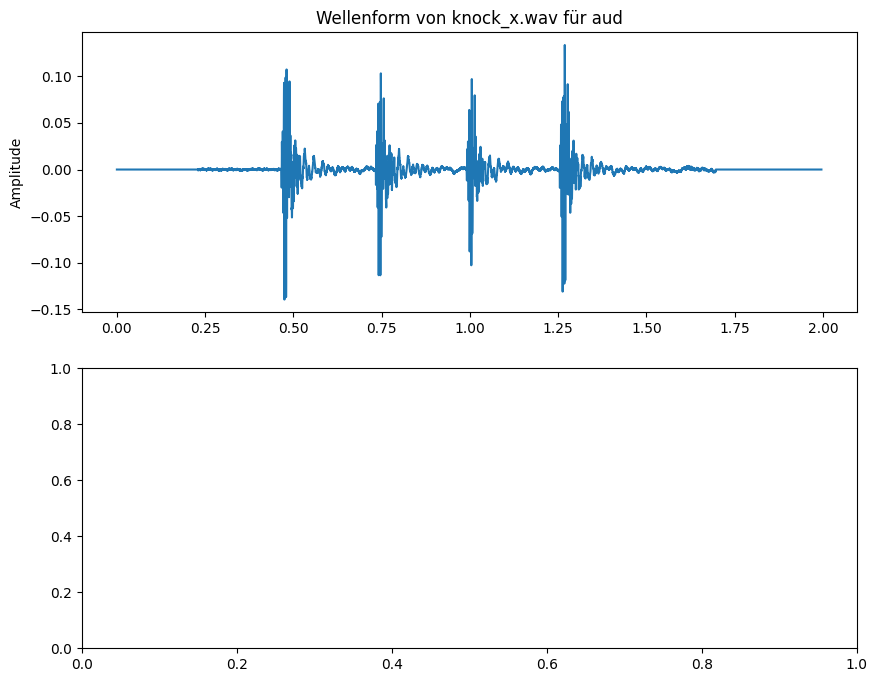

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Angenommen, aud ist ein NumPy-Array oder ähnliches, das direkt geplottet werden kann
# Wenn aud eine komplexere Struktur hat, müssen Sie es entsprechend extrahieren/konvertieren
aud = AudioUtil.open('knock_x.wav')
aud, sr = AudioUtil.pad_trunc(aud, 2000)
aud1 = AudioUtil.open('data/train/knock_1.wav')
aud1, sr = AudioUtil.pad_trunc(aud, 2000)
#tensor to np
aud = aud.numpy()[0] * 1
aud1 = aud1.numpy()[0] * 1
print(aud)

# Erstellen der Zeitachse basierend auf der Länge von aud und einer angenommenen Sample-Rate
# Wenn die tatsächliche Sample-Rate bekannt ist, ersetzen Sie 44100 durch diesen Wert
time = np.linspace(0, len(aud) / sr, num=len(aud))

fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # Erstellung von 2 Subplots übereinander

# Erster Subplot für aud
axs[0].plot(time, aud)
axs[0].set_title('Wellenform von knock_x.wav für aud')
axs[0].set_ylabel('Amplitude')

# Zweiter Subplot für aud1
axs[1].plot(time, aud1)
axs[1].set_title('Wellenform von knock_x.wav für aud1')
axs[1].set_xlabel('Zeit (s)')
axs[1].set_ylabel('Amplitude')

plt.tight_layout()  # Verbessert die Anordnung der Subplots
plt.show()